## 更新內容
>2021.3.25  Regression_model_release_v0.3.1
* add raw data overlay plot
* add response plot
* add drifting ratio and parameter plot

>2021.2.2  Regression_model_release_v0.3.0
* new version compensation
* upgrade plotly version v4.14.3 (原本 version v3.9.0)
* upgrade cufflinks version v0.17.3 (原本 version v0.15.0)
* white_card_coef 乘 parameter(for compensation)
* revise .csv filename

>2021.1.15 Regression_model_release_v0.2.6
* 更新interpolation模組
        * 增加線性外插高濃度值功能"__extrapolation_upper"
        * 增加線性外插低濃度值功能"__extrapolation_lower"
        * 增加指數外插高濃度值功能"__log_extrapolation_upper"
        * 增加指數外插低濃度值功能"__log_extrapolation_lower"
        * mark hybrid_interpolation function
        * 修正對數數值domain
  

## 程式主要功能 
* 建立各濃度平面
* 內差法計算濃度值

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

import tkinter
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
from tkinter import filedialog
%gui tk

import FFT
import compensation
import module_4D
# import modeling_white_card
import model
import white_card_std

# from modeling_white_card import modeling_white
# from modeling import modeling
import interpolation
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def data_loading():
    path = filedialog.askdirectory()
    print(path)
    return path

In [3]:
def ratio_calculator(df_qc, df_ref, channel):
    ratio = (df_qc[channel]/df_ref[channel]).mean()
    return ratio

# Compensation

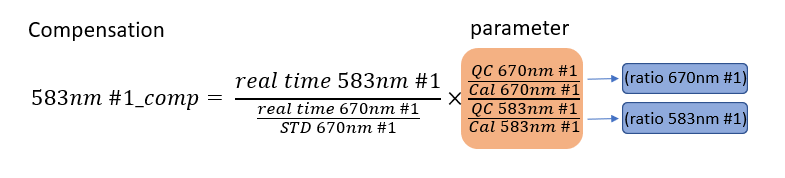
1. calculate parameter
2. build reference model
3. calculate ref_std

In [4]:
n = 8
a = 1
folder_name = 'test'
# folder_name = 'QC3_583nm_comp_log_model(K1+QC1)(degree 2)'

In [5]:
path_list = []
while a <= n:
    path = data_loading()
    path_list.append(path)
    a+=1

D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200721091847
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200721092104
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200721092450
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200722094552
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200723092707
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200724092914
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200727165442
D:/Data_store/AMS_7341/050421 Intemo MP test (U+4, 0~40C, 60%, 60, 25, 10, 4, 0ppm)/batch1/#20200803100505


In [9]:
for path in path_list:
    sensor_number = path.split('/')[-1]
    print('sensor_number:', sensor_number)
    
    A = 0
    B = 300000
    df_30C = pd.read_csv(path + '/select_data_calibration_30C.csv')[A:B].reset_index(drop=True)
    df_test_30C = pd.read_csv(path + '/select_data_blind_test_30C.csv')[A:B].reset_index(drop=True)
    df_test_30C_2 = pd.read_csv(path + '/select_data_blind_test_30C_2.csv')[A:B].reset_index(drop=True)
    df_test_30C_3 = pd.read_csv(path + '/select_data_blind_test_30C_3.csv')[A:B].reset_index(drop=True)
    df_test_30C_4 = pd.read_csv(path + '/select_data_blind_test_30C_4.csv')[A:B].reset_index(drop=True)
#     df_test_n10C_5 = pd.read_csv(path + '/select_data_blind_test_n10C_5.csv')[A:B].reset_index(drop=True)
#     df_test_n10C_6 = pd.read_csv(path + '/select_data_blind_test_n10C_6.csv')[A:B].reset_index(drop=True)
    
    test_data_list = [
                      df_30C,
                      df_test_30C, 
                      df_test_30C_2, 
                      df_test_30C_3, 
                      df_test_30C_4, 
#                       df_test_n10C_5, 
#                       df_test_n10C_6
                     ]
    
#     save_figure = True
    cal_channel = '583nm #1'
    QC_channel = '583nm #1'

    '''計算每次QC drift ratio變化'''
    mean_ratio_list = []   
    for i,j in enumerate(test_data_list):
        by_ratio = (j.iloc[10:, 7:13]-df_30C.iloc[10:, 7:13])/df_30C.iloc[10:, 7:13]
        mean_ratio_list.append(by_ratio.mean())
    df_by_mean_ratio = pd.DataFrame(mean_ratio_list)

    fig = px.line(df_by_mean_ratio)
    fig.show()  

    plot_data = []
    for i,j in enumerate(test_data_list):
        by_compensation = j.loc[:,'583nm #1']-j.loc[:,'510nm #1']
        trace_ppm = go.Scatter(y=by_compensation, name='round{}'.format(i+1))
        
#         trace_ppm = go.Scatter(y=j[QC_channel], name=QC_channel+' QC{}'.format(i+1))
        plot_data.append(trace_ppm)


#     title = '{} raw data overlay'.format(QC_channel)    
    layout = go.Layout()
    fig = go.Figure(data=plot_data, layout=layout)
#     fig.show()

sensor_number: #20200721091847


sensor_number: #20200721092104


sensor_number: #20200721092450


sensor_number: #20200722094552


sensor_number: #20200723092707


sensor_number: #20200724092914


sensor_number: #20200727165442


sensor_number: #20200803100505


In [ ]:

mean_ratio_list = []   
for i,j in enumerate(data_list):
    by_ratio = (j.iloc[10:, 7:13]-df_30C.iloc[10:, 7:13])/df_30C.iloc[10:, 7:13]
    mean_ratio_list.append(by_ratio.mean())
df_by_mean_ratio = pd.DataFrame(mean_ratio_list)

fig = px.line(df_by_mean_ratio)
fig.show()    